In [1]:
# External Dependencies

import random

import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.ndimage import laplace
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.linalg import solve
from scipy.spatial import distance_matrix
from scipy.ndimage import binary_fill_holes
from scipy.spatial import ConvexHull
from scipy.signal import correlate2d
from scipy.stats import wasserstein_distance
from scipy.stats import pearsonr

import pylops
from pylops.utils.wavelets import ricker

import gstools as gs

from sklearn.metrics.pairwise import cosine_similarity

from skimage.metrics import structural_similarity as ssim

import torch
import pywt
from skimage.metrics import structural_similarity as ssim

import seaborn as sns


# External files

execfile("OT_Lib_Functions.py")
execfile("Distance_Functions.py")

DTW C variant not available.

If you want to use the C libraries (not required, depends on cython), then run `cd d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\dtaidistance\..;python3 setup.py build_ext --inplace`.


In [648]:
del PPop

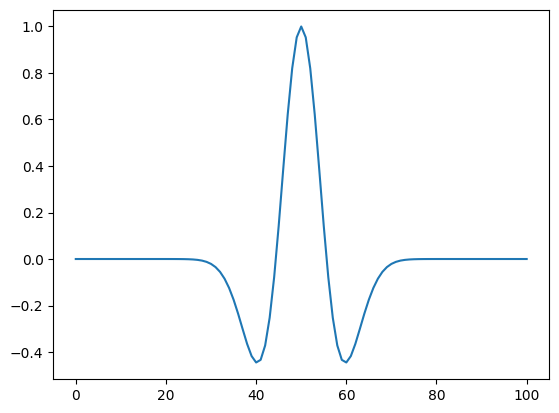

In [704]:
# Grid constants
nx, nz = 100, 100  # Grid size in nx (n, offset) and z (depth) directions
x = np.linspace(0, nx-1, nx)
z = np.linspace(0, -(nx-1), nz)
x_grid, z_grid = np.meshgrid(x, z)

# Impedance values
salt_impedance = 1
rock_impedance = 0

# Wavelet
nt0 = 51
dt0 = 0.002
t0 = np.arange(nt0) * dt0
ntwav = 101
wav, twav, wavc = ricker(t0[: ntwav // 2 + 1], 20)

plt.plot(wav)

# PyLops dense operator
PPop_dense = pylops.avo.poststack.PoststackLinearModelling(
    wav / 2, nt0=nz, spatdims=nx, explicit=True
)
# PyLops lop operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav / 2, nt0=nz, spatdims=nx)

In [705]:
# We make use of the software package OTlib.py, which implements the approach of Sambridge et al. (2022).
# https://github.com/msambridge/waveform-ot/tree/main

# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.


# choose grid to use

nugrid,ntgrid=40,512 # This is the discretization of the waveform window used to evaluated the density surface
lambdav = 1 #0.03       # This is the distance scale factor used to calculate the density function (eqn. 17 of Sambridge et al. (2

trange = [0, nx]

grid = (trange[0], trange[1], -1.0, 1.0, nugrid,ntgrid) # specify grid for fingerprint # -0.8, 1.2

In [697]:
# Structure functions

# Layers
def create_structure(type, structure_depth, structure_radius, struct_dip, structure_amplitude, structure_freq):
    structure = np.full((nz, nx), rock_impedance)
    structure_depth = structure_depth
    structure_radius = structure_radius
    structure_amplitude = structure_amplitude
    structure_freq = structure_freq

    if type == 'flat':
        for i in range(nz):
            for j in range(nx):
                # Flat shape
                depth = structure_depth
                if i < depth:
                    structure[i, j] = salt_impedance

    if type == 'dip':
        for i in range(nz):
            for j in range(nx):
                # Dipping shape
                depth = structure_depth + j * struct_dip
                if i < depth:
                   structure[i, j] = salt_impedance
    
    if type == 'dome':
        for i in range(nz):
            for j in range(nx):
                # Parabolic shape
                depth = structure_depth + (j - nx // 2)**2 / (2 * structure_radius)
                if i < depth:
                   structure[i, j] = salt_impedance

    if type == 'sin':
        for i in range(nz):
            for j in range(nx):
                # Sinusoidal shape
                depth = structure_depth + structure_amplitude * np.sin(j * structure_freq)
                if i < depth:
                   structure[i, j] = salt_impedance

    return structure


# Boundaries
def create_structure_boundary(type, structure_depth, structure_radius, struct_dip, structure_amplitude, structure_freq):
    if type == 'flat':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth

    if type == 'dip':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth + j * struct_dip

    if type == 'dome':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth + (j - nx // 2)**2 / (2 * structure_radius)

    if type == 'sin':
        boundary_depth = np.zeros((nx))
        for j in range(nx):
            boundary_depth[j] = structure_depth + structure_amplitude * np.sin(j * structure_freq)
    
    return boundary_depth

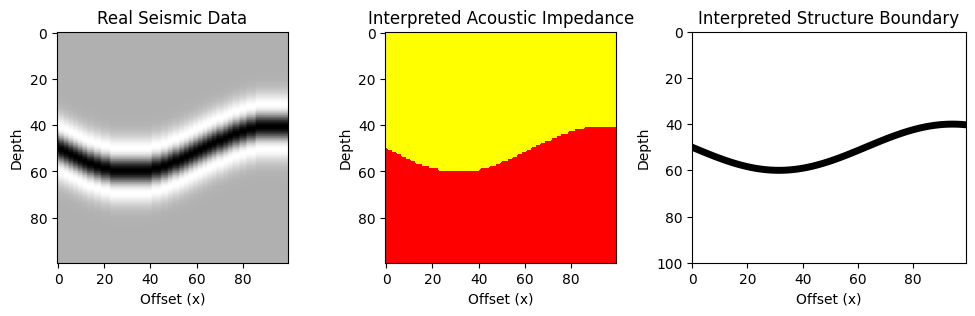

In [ ]:
# Create initial structure

structure_type = 'sin'
structure_depth = 50
structure_radius = 20
struct_dip=0.3
structure_freq = 0.05
structure_amplitude = 10


initial_structure = create_structure(type=structure_type,
                                     structure_depth=structure_depth,
                                     structure_radius=structure_radius,
                                     struct_dip=struct_dip,
                                     structure_amplitude=structure_amplitude,
                                     structure_freq=structure_freq
                                    )

# Activate for a mix of structures

#structure_type = 'sin'
#initial_structure = initial_structure + create_structure(type=structure_type,
#                                                         structure_depth=structure_depth,
#                                                         structure_radius=structure_radius,
#                                                         struct_dip=struct_dip,
#                                                         structure_amplitude=structure_amplitude,
#                                                         structure_freq=structure_freq
#                                                        )


# Shift and substraction of initial structure to obtain the structure boundary
initial_structure_temp = np.zeros((nz, nx))
initial_structure_temp[0:nz-1, :] = initial_structure[1:, :]
initial_structure_boundary = initial_structure - initial_structure_temp
initial_structure_boundary[nz-1, :] = 0
# For visualization
initial_structure_boundary_for_visualization = (initial_structure_boundary - 1)*(-1)


# Initial seismic data for the initial structure
initial_mi = initial_structure
initial_di = (PPop_dense * initial_mi.ravel()).reshape(nz, nx)
initial_ni = np.random.normal(0, 0.1e-1, initial_di.shape)
initial_dn = initial_di #+ initial_ni


# Create structure boundary for plot
bd = create_structure_boundary(structure_type, structure_depth, structure_radius, struct_dip, structure_amplitude, structure_freq)

# Plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# RF perturbations
#axes[2].imshow(initial_structure_boundary_for_visualization, cmap="gray")
axes[2].plot(np.linspace(0, 99, 100), bd, lw=5, color='black')
axes[2].set_ylim(0, 100)
plt.gca().invert_yaxis()
plt.margins(0,0)
axes[2].set_ylabel("Depth")
axes[2].set_xlabel("Offset (x)")
axes[2].set_title("Interpreted Structure Boundary")

# Impedance
axes[0].imshow(initial_dn, cmap="gray")
axes[0].set_ylabel("Depth")
axes[0].set_xlabel("Offset (x)")
axes[0].set_title("Real Seismic Data")

# Seismic
import matplotlib as mpl
axes[1].imshow(initial_structure, cmap=(mpl.colors.ListedColormap(['red', 'yellow'])
        .with_extremes(over='yellow', under='red')))
axes[1].set_ylabel("Depth")
axes[1].set_xlabel("Offset (x)")
axes[1].set_title("Interpreted Acoustic Impedance")

#plt.tight_layout()
plt.show()

In [37]:
# Definitions of functions for model generation

# Impedance
def generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget, sill, current_range):

    # SRF with added initial structure as the base
    len_sc = current_range
    model = gs.Gaussian(dim=1, var=sill, len_scale=current_range)
    srf = gs.SRF(model, mean=0)
    #simulated_realization = srf((np.linspace(0, nx-1, nx)), mesh_type="structured")
    simulated_realization = srf.structured(np.linspace(0, nx-1, nx))

    # Conditioned SRF
    bh_locations = [0, 99]
    bh_values = [0, 0]
    # Conditioning of the SRF to the specified points
    krige = gs.krige.Simple(model, bh_locations, bh_values)
    cond_srf = gs.CondSRF(krige)
    x_offset = np.linspace(0, nx-1, nx)
    conditioned_simulated_realization = cond_srf(x_offset)



    # Structure and perturbation
    boundary_depth = create_structure_boundary(#type=random.choice(['flat','dip','dome','sin']),
                                               type='flat',
                                               structure_depth=structure_depth,
                                               structure_radius=structure_radius,
                                               struct_dip=struct_dip,
                                               structure_amplitude=structure_amplitude,
                                               structure_freq=structure_freq  * np.random.uniform(0.95, 1.05)
                                              )
    perturbed_structure = np.full((nz, nx), rock_impedance)
    perturbed_depth = boundary_depth + conditioned_simulated_realization
    for i in range(nz):
        for j in range(nx):
            depth = perturbed_depth[j]
            if i < depth:
                perturbed_structure[i, j] = salt_impedance

    # Perturbed structure
    return perturbed_structure, conditioned_simulated_realization
  

#Seismic
def generate_seismic_model(impedance):

    # Generate corresponding seismic data for impedance
    m = impedance
    # data
    d = (PPop_dense * m.ravel()).reshape(nz, nx)
    n = np.random.normal(0, 0.1e-1, d.shape)
    dn = d #+ n

    # Seismic
    return dn


# Covariance function
def compute_covariance_2D(data, range_param, sill):
    n_rows, n_cols = data.shape
    grid_points = np.array([(i, j) for i in range(n_rows) for j in range(n_cols)])
    distances = cdist(grid_points, grid_points, metric='euclidean')
    
    # Exponential variogram model
    covariance_matrix = sill * np.exp(-distances / range_param)
    
    # Covariance matrix
    return covariance_matrix


In [605]:
# Definitions of functions for the MCMC

# Likelihood function
def compute_likelihood(simulated_data, observed_data):

    """Calculates the likelihood based on the mean squared error."""
    #mse = np.mean((simulated_data - observed_data)**2)
    #ssim_error = compute_wasserstein_distance(simulated_data, observed_data)
    ssim_error = compute_least_squares_misfit(simulated_data, observed_data) 
    #ssim_error = compute_OT_2(simulated_data, observed_data)

    # Convert error to a likelihood, assuming Gaussian errors
    likelihood = np.exp(-ssim_error/2.0)

    #likelihood = np.log(ssim_error)
    #likelihood = ssim_error

    return likelihood, ssim_error

# Bayesian MC sampling for the range parameter
def mc_bayesian_estimation(observed_data, current_range, current_variance, current_nugget, step_size, n_samples):
    
    

    # MCMC Posterior distribution
    likelihood = []
    # Models through iterations, for plot and QC
    len_sc_list = []
    realizations_SRF = []
    realizations_impedance = []
    realizations_seismic = []
    realizations_seismic_norm = []
    realizations_seismic_norm_mean = []
    realizations_seismic_norm_std = []
    similarity = np.zeros((n_samples+1))
    variances = []
    nuggets = []

    #current_impedance = sgs_simulation(impedance_1, compute_covariance_2D(impedance_1, range_param=current_range), nugget, sill, current_range)
    current_impedance, current_SRF_model = generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget=current_nugget, sill=current_variance, current_range=current_range)
    current_seismic = generate_seismic_model(current_impedance)
    current_seismic_norm = (current_seismic - np.mean(current_seismic)) / np.std(current_seismic)
    current_likelihood, sim_ = compute_likelihood(current_seismic, observed_data)

    likelihood.append(current_likelihood)

    # Save current data for plots
    len_sc_list.append(current_range)
    variances.append(current_variance)
    nuggets.append(current_nugget)
    realizations_SRF.append(current_SRF_model)
    realizations_impedance.append(current_impedance)
    realizations_seismic.append(current_seismic)

    
    realizations_seismic_norm.append(current_seismic_norm)
    realizations_seismic_norm_mean.append(np.mean(current_seismic))
    realizations_seismic_norm_std.append(np.std(current_seismic))

    similarity[0] = sim_

    for i in tqdm(range(n_samples)):
       
        # New/Current range
        current_range = rng.uniform(prior_range_min, prior_range_max)
        #current_range = np.random.normal(70, 20)
        current_variance = rng.uniform(prior_variance_min, prior_variance_max)
        current_nugget = rng.uniform(prior_nugget_min, prior_nugget_max)

        # Generate seismic data with the proposed range
        #proposed_impedance = sgs_simulation(current_impedance, compute_covariance_2D(current_impedance, range_param=proposed_range), nugget, sill, proposed_range)
        current_impedance, current_SRF_model = generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget=current_nugget, sill=current_variance, current_range=current_range)
        current_seismic = generate_seismic_model(current_impedance)
        current_seismic_norm = (current_seismic - np.mean(current_seismic)) / np.std(current_seismic)
        current_likelihood, sim_ = compute_likelihood(current_seismic, observed_data)

        # Append the current accepted range to likelihood
        likelihood.append(current_likelihood)

        # Save data for plots
        len_sc_list.append(current_range)
        variances.append(current_variance)
        nuggets.append(current_nugget)
        realizations_SRF.append(current_SRF_model)
        realizations_impedance.append(current_impedance)
        realizations_seismic.append(current_seismic)

        current_seismic_norm = (current_seismic - np.mean(current_seismic)) / np.std(current_seismic)
        realizations_seismic_norm.append(current_seismic_norm)
        realizations_seismic_norm_mean.append(np.mean(current_seismic))
        realizations_seismic_norm_std.append(np.std(current_seismic))

        similarity[i+1] = sim_

    #likelihood = np.array(likelihood)
    # Normalize weights (to ensure they sum to 1)
    total_weight = np.sum(likelihood)
    normalized_weights = [w / total_weight for w in likelihood]
    # Perform weighted averaging over samples (or use them to estimate the posterior)
    weighted_samples = np.average(likelihood, axis=0, weights=normalized_weights)
    #plt.plot(normalized_weights)
    
    return np.array(likelihood), len_sc_list, variances, nuggets, realizations_SRF, realizations_impedance, realizations_seismic, \
        realizations_seismic_norm, realizations_seismic_norm_mean, realizations_seismic_norm_std, similarity, weighted_samples


# Bayesian MCMC
def mcmc_bayesian_estimation(observed_data, current_range, current_variance, current_nugget, step_size, n_samples):

    # MCMC Posterior distribution
    likelihood = []

    # Models through iterations, for plot and QC
    len_sc_list = []
    realizations_SRF = []
    realizations_impedance = []
    realizations_seismic = []
    realizations_seismic_norm = []
    realizations_seismic_norm_mean = []
    realizations_seismic_norm_std = []
    similarity = np.zeros((n_samples+1))
    variances = []
    nuggets = []

    #current_impedance = sgs_simulation(impedance_1, compute_covariance_2D(impedance_1, range_param=current_range), nugget, sill, current_range)
    current_impedance, current_SRF_model = generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget=0, sill=current_variance, current_range=current_range)
    current_seismic = generate_seismic_model(current_impedance)
    current_seismic_norm = (current_seismic - np.mean(current_seismic)) / np.std(current_seismic)
    current_likelihood, sim_ = compute_likelihood(current_seismic_norm, observed_data)

    likelihood.append(current_likelihood)

    # Save current data for plots
    len_sc_list.append(current_range)
    variances.append(current_variance)
    nuggets.append(current_nugget)
    realizations_SRF.append(current_SRF_model)
    realizations_impedance.append(current_impedance)
    realizations_seismic.append(current_seismic)

    
    realizations_seismic_norm.append(current_seismic_norm)
    realizations_seismic_norm_mean.append(np.mean(current_seismic))
    realizations_seismic_norm_std.append(np.std(current_seismic))

    similarity[0] = sim_

    for i in tqdm(range(n_samples)):

        # Propose a new range by adding a small Gaussian perturbation
        proposed_range = current_range + np.random.normal(0, step_size)
        proposed_variance = current_variance + np.random.normal(0, step_size)
        proposed_nugget = current_nugget + np.random.normal(0, step_size/2)

        # Keep proposed values within bounds
        proposed_range = np.clip(proposed_range, prior_range_min, prior_range_max)
        proposed_variance = np.clip(proposed_variance, prior_variance_min, prior_variance_max)
        proposed_nugget = np.clip(proposed_variance, prior_nugget_min, prior_nugget_max)

        #if proposed_range < prior_range_min or proposed_range > prior_range_max:
        #    # Skip if proposed range is outside prior bounds
        #    continue

        # Generate seismic data with the proposed range
        #proposed_impedance = sgs_simulation(current_impedance, compute_covariance_2D(current_impedance, range_param=proposed_range), nugget, sill, proposed_range)
        proposed_impedance, proposed_SRF_model = generate_impedance_model(nz, nx, salt_impedance, rock_impedance, nugget=0, sill=proposed_variance, current_range=proposed_range)
        proposed_seismic = generate_seismic_model(proposed_impedance)
        proposed_seismic_norm = (proposed_seismic - np.mean(proposed_seismic)) / np.std(proposed_seismic)
        proposed_likelihood, sim_ = compute_likelihood(proposed_seismic_norm, observed_data)

        # Acceptance probability (Metropolis-Hastings)
        acceptance_ratio = proposed_likelihood / current_likelihood
        #print(acceptance_ratio)
        if np.random.rand() < acceptance_ratio:
            # Accept the proposal
            current_range = proposed_range
            current_variance = proposed_variance
            current_nugget = proposed_nugget
            current_likelihood = proposed_likelihood


        #print(f"Iteration {i}: Proposed range: {proposed_range}, Likelihood ratio: {acceptance_ratio}")
        #print(f"Observed data mean: {np.mean(observed_data)}, std: {np.std(observed_data)}")
        #print(f"Initial simulated seismic mean: {np.mean(current_seismic)}, std: {np.std(current_seismic)}")

        # Append the current accepted range to likelihood
        likelihood.append(proposed_likelihood)

        # Save data for plots
        len_sc_list.append(proposed_range)
        variances.append(proposed_variance)
        nuggets.append(proposed_nugget)
        realizations_SRF.append(proposed_SRF_model)
        realizations_impedance.append(proposed_impedance)
        realizations_seismic.append(proposed_seismic)

        seis_norm = (current_seismic - np.mean(current_seismic)) / np.std(current_seismic)
        realizations_seismic_norm.append(proposed_seismic_norm)
        realizations_seismic_norm_mean.append(np.mean(current_seismic))
        realizations_seismic_norm_std.append(np.std(current_seismic))

        similarity[i+1] = sim_

    weighted_samples = 0 # CORRECT, leaving zero to have the same number of function parameters as MC 


    return np.array(likelihood), len_sc_list, variances, nuggets, realizations_SRF, realizations_impedance, realizations_seismic, \
        realizations_seismic_norm, realizations_seismic_norm_mean, realizations_seismic_norm_std, similarity, weighted_samples

In [618]:
# MC/MCMC sampling

rng = np.random.default_rng(seed=1234)

# Prior distribution for the variogram parameters
prior_variance_min = 0.5
prior_variance_max = 200
current_variance = rng.uniform(prior_variance_min, prior_variance_max)
prior_range_min = 1
prior_range_max = 100
current_range = rng.uniform(prior_range_min, prior_range_max)
prior_nugget_min = 1
prior_nugget_max = 50
current_nugget = rng.uniform(prior_nugget_min, prior_nugget_max)
#current_range = np.random.normal(70, 20)

# Observed seismic data
observed_data = initial_dn

observed_data_norm = (observed_data - np.mean(observed_data))/np.std(observed_data)



n_samples = 10000
step_size = 50.0

# Select MC or MCMC function, mc_bayesian_estimation or mcmc_bayesian_estimation
posterior_samples, len_sc_list, variances, nuggets, realizations_SRF, realizations_impedance, \
    realizations_seismic, realizations_seismic_norm, realizations_seismic_norm_mean, \
        realizations_seismic_norm_std, similarity, weighted_samples = mc_bayesian_estimation(observed_data,
                                                                           current_range=current_range,
                                                                           current_variance=current_variance,
                                                                           current_nugget=current_nugget,
                                                                           step_size=step_size,
                                                                           n_samples=n_samples
                                                                          )

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:22<00:00, 70.37it/s]
C:\Users\cco\AppData\Local\Temp\ipykernel_21752\392914600.py:98: RuntimeWarning: invalid value encountered in scalar divide
  normalized_weights = [w / total_weight for w in likelihood]


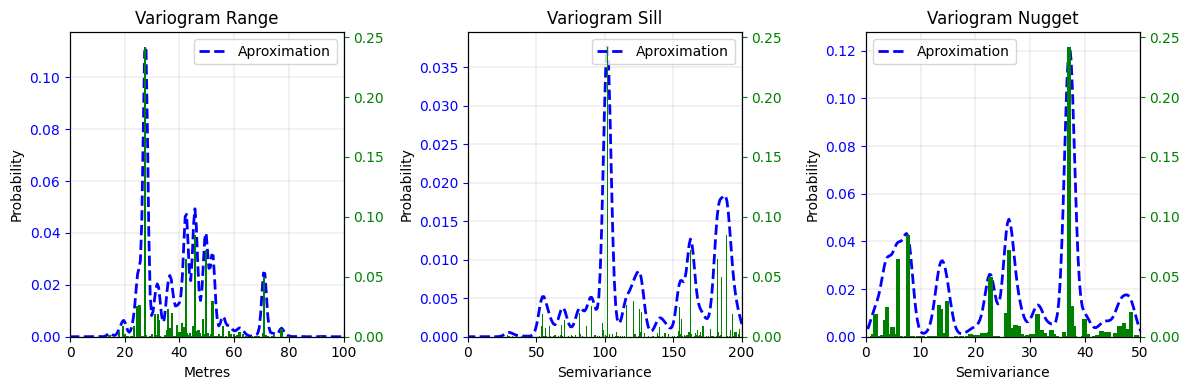

In [621]:
# Plot distributions

# Compute likelihood from error (instead of, directly, from the computed likelihood value)
l_temp = similarity / np.sum(similarity)
l_ = l_temp/np.sum(l_temp)
l_ = (np.exp((-0.5 * (l_temp**2) / np.std(l_temp)**2))) / np.sum(np.exp((-0.5 * (l_temp**2) / np.std(l_temp)**2)))
np.sum(l_)


# Plots

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.kdeplot(x=len_sc_list, weights=l_, color='blue', linestyle='--', linewidth=2, bw_adjust=.1, label='Aproximation')
axes[0].set_xlim(0, prior_range_max)
#plt.ylim(0, 0.05)
axes[0].set_title("Variogram Range")
axes[0].set_xlabel("Metres")
axes[0].set_ylabel("Probability")
axes[0].tick_params(axis='y', colors='blue')
axes[0].legend()
plt.grid("minor", linewidth=0.25)
plt.twinx()
plt.bar(len_sc_list, l_, color='green')
plt.tick_params(axis='y', colors='green')


plt.subplot(1, 3, 2)
sns.kdeplot(x=variances, weights=l_, color='blue', linestyle='--', linewidth=2, bw_adjust=.1, label='Aproximation')
axes[1].set_xlim(0, prior_variance_max)
#plt.ylim(0, 0.05)
axes[1].set_title("Variogram Sill")
axes[1].set_xlabel("Semivariance")
axes[1].set_ylabel("Probability")
axes[1].tick_params(axis='y', colors='blue')
axes[1].legend()
plt.grid("minor", linewidth=0.25)
plt.twinx()
plt.bar(variances, l_, color='green')
plt.tick_params(axis='y', colors='green')

plt.subplot(1, 3, 3)
sns.kdeplot(x=nuggets, weights=l_, color='blue', linestyle='--', linewidth=2, bw_adjust=.1, label='Aproximation')
axes[2].set_xlim(0, prior_nugget_max)
#plt.ylim(0, 0.05)
axes[2].set_title("Variogram Nugget")
axes[2].set_xlabel("Semivariance")
axes[2].set_ylabel("Probability")
axes[2].tick_params(axis='y', colors='blue')
axes[2].legend()
plt.grid("minor", linewidth=0.25)
plt.twinx()
plt.bar(nuggets, l_, color='green')
plt.tick_params(axis='y', colors='green')

plt.tight_layout()
plt.show()

In [631]:
l_temp = similarity / np.sum(similarity)
l_ = l_temp/np.sum(l_temp)
l_ = (np.exp((-0.5 * (l_temp**2) / np.std(l_temp)**2))) / np.sum(np.exp((-0.5 * (l_temp**2) / np.std(l_temp)**2)))
np.sum(l_)

0.9999999999999999

In [421]:
l_ = 1-similarity/np.sum(similarity)
np.sum(l_/30)

1.0

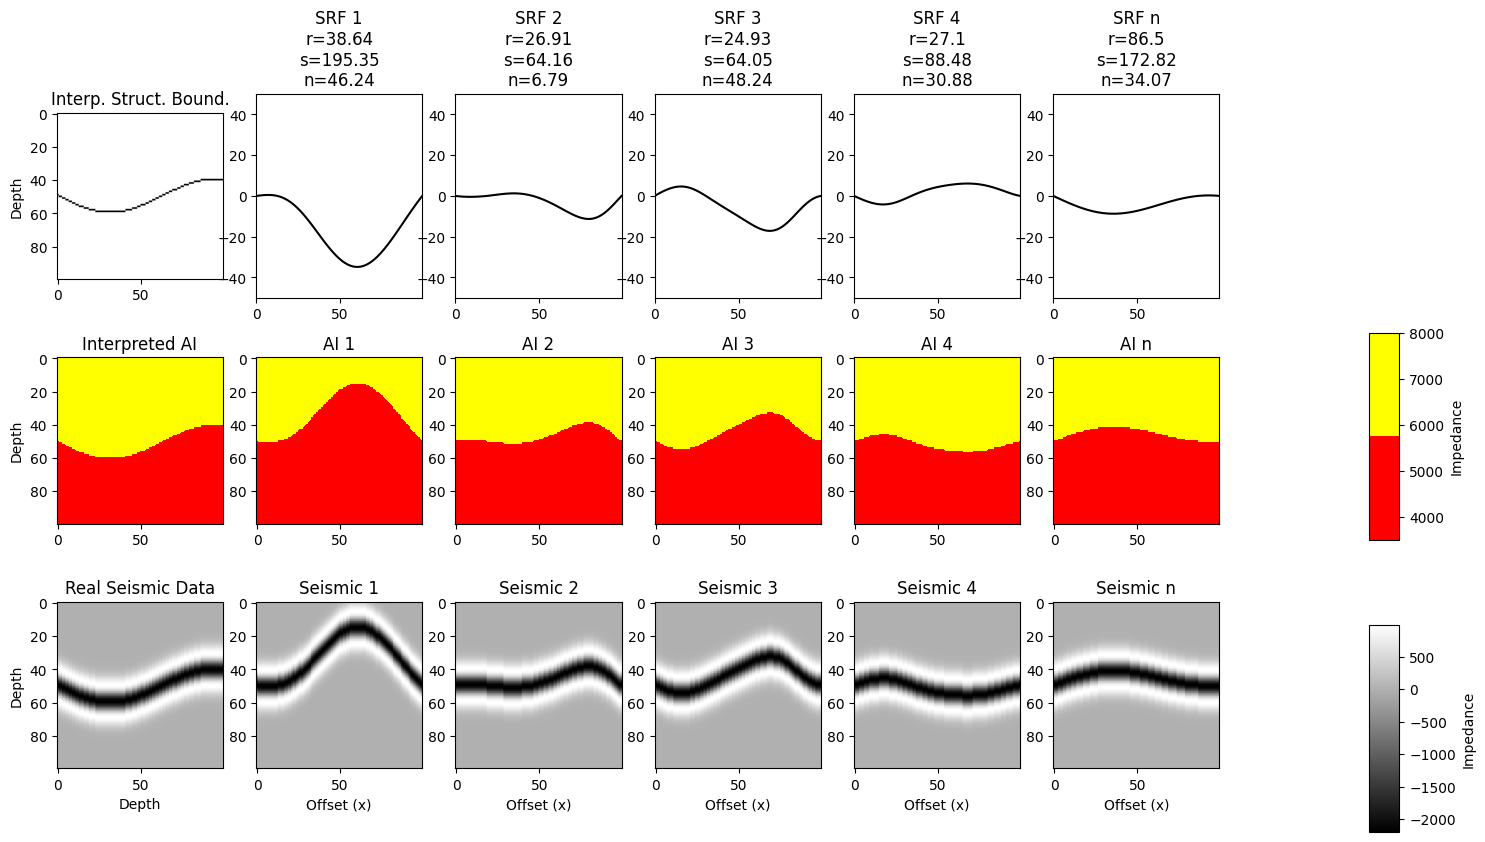

In [757]:
# Plots models

fig, axes = plt.subplots(3, 5 + 1, figsize=(15, 9))

# First row, SRF perturbations
axes[0, 0].imshow(initial_structure_boundary_for_visualization, cmap="gray")
axes[0, 0].set_title("Interp. Struct. Bound.")
axes[0 ,0].set_ylabel("Depth")

for i, realization in enumerate(realizations_SRF[0:5]):
    axes[0, i+1].plot(realization, color="black")
    axes[0, i+1].margins(0)
    axes[0, i+1].set_title(f"SRF {i+1}\nr={round(len_sc_list[i],2)}\ns={round(variances[i],2)}\nn={round(nuggets[i],2)}")
    axes[0, i+1].set_ylim(-50, 50)
    if i == 4:
        axes[0, i+1].set_title(f"SRF n\nr={round(len_sc_list[i],2)}\ns={round(variances[i],2)}\nn={round(nuggets[i],2)}")

# Second row, impedance realizations
axes[1, 0].imshow(initial_structure, cmap=(mpl.colors.ListedColormap(['red', 'yellow']).with_extremes(over='yellow', under='red')))
axes[1, 0].set_title("Interpreted AI")
axes[1, 0].set_ylabel("Depth")
if i == 4:
        axes[1, i+1].set_title(f"Seismic n")

for i in range (5):
    axes[1, i+1].imshow(realizations_impedance[i], cmap=(mpl.colors.ListedColormap(['red', 'yellow']).with_extremes(over='yellow', under='red')))
    axes[1, i+1].set_title(f"AI {i+1}")
    if i == 4:
        axes[1, i+1].set_title(f"AI n")

# Third row, seismic realizations
axes[2, 0].imshow(initial_dn, cmap="gray")
axes[2, 0].set_title("Real Seismic Data")
axes[2, 0].set_xlabel("Depth")
axes[2, 0].set_ylabel("Depth")

for i, realization in enumerate(realizations_seismic[0:5]):
    axes[2, i+1].imshow(realization, cmap="gray")
    axes[2, i+1].set_title(f"Seismic {i+1}")
    axes[2, i+1].set_xlabel("Offset (x)")
    if i == 4:
        axes[2, i+1].set_title(f"Seismic n")


# Colorbar for impedance
cbar_ax_imp = fig.add_axes([1.0, 0.385, 0.02, 0.23])  # [left, bottom, width, height]
cbar_imp = fig.colorbar(axes[1, 1].images[0], cax=cbar_ax_imp, orientation='vertical')
cbar_imp.set_label('Impedance')

# Colorbar for seismic
cbar_ax_seis = fig.add_axes([1.0, 0.06, 0.02, 0.23])  # [left, bottom, width, height]
cbar_imp = fig.colorbar(axes[2, 1].images[0], cax=cbar_ax_seis, orientation='vertical')
cbar_imp.set_label('Impedance')


#plt.tight_layout()
plt.show()

In [ ]:
# MCMC Plot similarities for different methods

# Constants
variance = 100
prior_range_min = 1
prior_range_max = 5000
current_range = np.random.uniform(prior_range_min, prior_range_max)
n_samples = 10
step_size = 2.0

# Data
#observed_data = initial_dn
#simulated_data = realizations_seismic[0]

# Plots

print("Start")

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_ssim(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[0, 0].scatter(len_sc_list, similarity_points)
axes[0, 0].set_title("SSIM")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_mae(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[0, 1].scatter(len_sc_list, similarity_points)
axes[0, 1].set_title("MAE")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_nrmse(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[0, 2].scatter(len_sc_list, similarity_points)
axes[0, 2].set_title("NRMSE")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_correlation(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[0, 3].scatter(len_sc_list, similarity_points)
axes[0, 3].set_title("Correlation")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_ssim(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[0, 4].scatter(len_sc_list, similarity_points)
axes[0, 4].set_title("SSIM")

print("5 plots completed")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_dtw(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[1, 0].scatter(len_sc_list, similarity_points)
axes[1, 0].set_title("Dynamic Time Warping")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_energy_difference(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[1, 1].scatter(len_sc_list, similarity_points)
axes[1, 1].set_title("Energy Difference")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_emd(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[1, 2].scatter(len_sc_list, similarity_points)
axes[1, 2].set_title("EMD")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_cross_correlation(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[1, 3].scatter(len_sc_list, similarity_points)
axes[1, 3].set_title("Cross-correlation")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_pearson_correlation(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[1, 4].scatter(len_sc_list, similarity_points)
axes[1, 4].set_title("Pearson Correlation")

print("10 plots completed")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_element_wise_multiplication(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[2, 0].scatter(len_sc_list, similarity_points)
axes[2, 0].set_title("Element-wise Multiplication")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_wavelet_transform(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[2, 1].scatter(len_sc_list, similarity_points)
axes[2, 1].set_title("Wavelet Transform")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_difference_and_total_sum(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[2, 2].scatter(len_sc_list, similarity_points)
axes[2, 2].set_title("Difference and Total Sum")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_cosine_similarity_seismic(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[2, 3].scatter(len_sc_list, similarity_points)
axes[2, 3].set_title("Cosine Similarity")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_semblance(realizations_seismic[i], observed_data)[1]
    similarity_points.append(sim_)
axes[2, 4].scatter(len_sc_list, similarity_points)
axes[2, 4].set_title("Semblance Sum")

print("15 plots completed")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_combined_semblance(realizations_seismic[i], observed_data)[1]
    similarity_points.append(sim_)
axes[3, 0].scatter(len_sc_list, similarity_points)
axes[3, 0].set_title("Combined Semblance Sum")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_wavelet_distance(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[3, 1].scatter(len_sc_list, similarity_points)
axes[3, 1].set_title("Wavelet Distance")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_hausdorff(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[3, 2].scatter(len_sc_list, similarity_points)
axes[3, 2].set_title("Hausdorff Distance")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_OT(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[3, 3].scatter(len_sc_list, similarity_points)
axes[3, 3].set_title("Optimal Transport 1")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_OT_2(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[3, 4].scatter(len_sc_list, similarity_points)
axes[3, 4].set_title("Optimal Transport 2")

print("20 plots completed")

similarity_points = []
for i in range(len(realizations_seismic)):
    sim_ = compute_OT_3(realizations_seismic[i], observed_data)
    similarity_points.append(sim_)
axes[4, 0].scatter(len_sc_list, similarity_points)
axes[4, 0].set_title("Optimal Transport 3")

plt.tight_layout()
plt.show()

#### Additional QC Tools

In [ ]:
# Compute semblance plots if needed

window_size = 10  # Define a window size
seismic_section = observed_data
semblance_map, semblance_sum = compute_semblance(initial_dn, realizations_seismic[0])

print(semblance_sum)

# Plot the original seismic section and semblance map
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.imshow(initial_dn, aspect='auto', cmap='grey', extent=[0, 100, 100, 0])
plt.title("Seismic Section")
plt.colorbar(label="Amplitude")

plt.subplot(1, 3, 2)
plt.imshow(realizations_seismic[0], aspect='auto', cmap='grey', extent=[0, 100, 100, 0])
plt.title("Seismic Section")
plt.colorbar(label="Amplitude")

plt.subplot(1, 3, 3)
plt.imshow(semblance_map, aspect='auto', cmap='seismic')
plt.title("Semblance Map")
plt.colorbar(label="Semblance")

plt.tight_layout()
plt.show()

In [ ]:
# Wavelet transform if needed

image1 = initial_dn
image2 = realizations_seismic[0]

# Convert images to PyTorch tensors
image1_tensor = torch.tensor(image1)
image2_tensor = torch.tensor(image2)

# 2D wavelet transform using PyWavelets
def wavelet_transform_2d(image):
    # Perform 2D wavelet transform (Haar wavelet)
    coeffs2 = pywt.dwt2(image, 'haar')
    return coeffs2

def inverse_wavelet_transform_2d(coeffs2):
    # Reconstruct the image from wavelet coefficients
    return pywt.idwt2(coeffs2, 'haar')

# Wavelet transform to both images
coeffs1 = wavelet_transform_2d(image1)
coeffs2 = wavelet_transform_2d(image2)

# Reconstruction of images from wavelet coefficients
reconstructed_image1 = inverse_wavelet_transform_2d(coeffs1)
reconstructed_image2 = inverse_wavelet_transform_2d(coeffs2)

# Reconstructed images back to NumPy arrays for comparison
reconstructed_image1 = reconstructed_image1
reconstructed_image2 = reconstructed_image2

# Structural Similarity Index between the original images
similarity_index, _ = ssim(image1, image2, full=True, data_range=1)

# Display SSIM score
print(f"Similarity Index (SSIM): {similarity_index}")


# Plots
plt.figure(figsize=(12, 8))

# Original Images
plt.subplot(2, 2, 1)
plt.imshow(image1, cmap="gray")
plt.title("Original Image 1")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(image2, cmap="gray")
plt.title("Original Image 2")
plt.colorbar()

# Reconstructed Images
plt.subplot(2, 2, 3)
plt.imshow(reconstructed_image1, cmap="gray")
plt.title("Reconstructed Image 1")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(reconstructed_image2, cmap="gray")
plt.title("Reconstructed Image 2")
plt.colorbar()

plt.tight_layout()
plt.show()


Wasserstein distance: 2.0435209659946426e-09


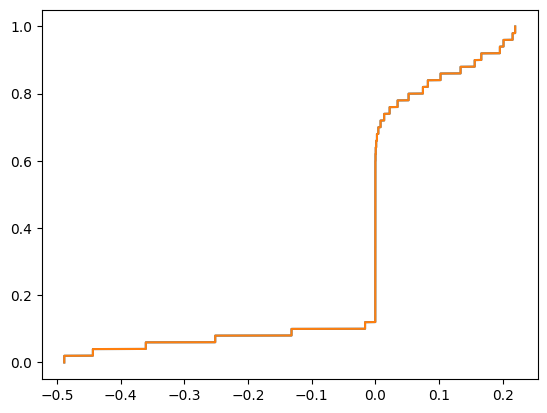

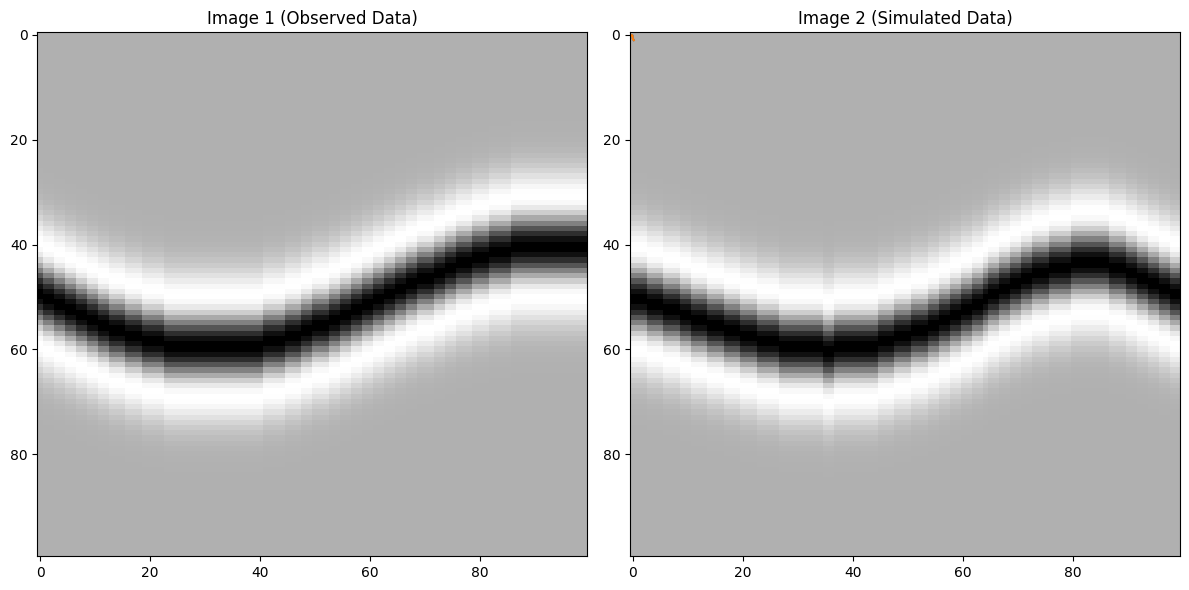

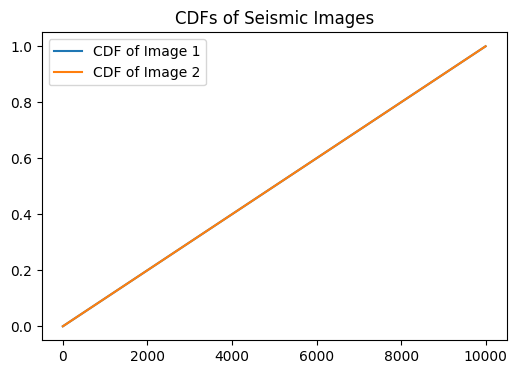

In [69]:
# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.


def time_amplitude_window (section):

    t_prima = np.arange(len(section.flatten())) / len(section.flatten())
    u_prima = 1/2 + 1/np.pi * np.arctan(1/(np.max(section)-np.min(section))*(2*section-section[0]-section[1]))

    return t_prima, u_prima


def calculation_of_CDF(section):

    # Flatten and sort
    sorted_values = np.sort(section.flatten())
    #sorted_values = np.linspace(0, len(section.flatten()), len(section.flatten()))
    
    # Compute CDF
    cdf = np.arange(len(section.flatten())) / (len(section.flatten()) )

    #xi = np.zeros((len(section.flatten())))
    #Fi = np.zeros((len(section.flatten())))
    #for i in range(0, len(section.flatten())):
    #    xi[i] = i
    #    if i < sorted_values[0]:
    #            Fi[i] = 0  # Case: x < x_1
    #    elif i >= sorted_values[-1]:
    #        Fi[i] = 1  # Case: x >= x_nf
    #    else:
    #        # Case: x_i <= x < x_{i+1}
    #        for j in range(len(sorted_values) - 1):
    #            if sorted_values[j] <= xi[i] < sorted_values[j + 1]:
    #                Fi[i] = cdf[j]


    plt.plot(sorted_values, cdf)
    #plt.plot(xi, Fi)
    
    # Return CDF and corresponding x-values
    return cdf, sorted_values


def compute_inverse_CDF(cdf, x_vals):

    # Interpolation of inverse CDF
    inv_cdf = np.interp(np.linspace(0, 1, len(cdf)), cdf, x_vals)
    return inv_cdf


def compute_wasserstein_distance(image1, image2):

    # Computation of the CDFs of both images
    cdf1, x_vals1 = calculation_of_CDF(image1)
    cdf2, x_vals2 = calculation_of_CDF(image2)
    
    # Computation of the inverse CDFs of both images
    inv_cdf1 = compute_inverse_CDF(cdf1, x_vals1)
    inv_cdf2 = compute_inverse_CDF(cdf2, x_vals2)
    
    #plt.plot(inv_cdf1)
    #plt.plot(inv_cdf2)


    # Computation of Wasserstein distance (eq. 30)
    # Sum of absolute differences between the inverse CDFs
    wasserstein_dist = np.sum(np.abs(inv_cdf1 - inv_cdf2))# * (x_vals1[1] - x_vals1[0])
    
    return wasserstein_dist


# Seismic data
image1 = observed_data
image2 = realizations_seismic[1953]

# Computation of Wasserstein distance between the two seismic sections
dist = compute_wasserstein_distance(image1, image2)

# Output
print(f"Wasserstein distance: {dist}")

# Plots
plt.figure(figsize=(12, 6))

# Plot image1 and image2
plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray', aspect='auto')
plt.title('Image 1 (Observed Data)')

plt.subplot(1, 2, 2)
plt.imshow(image2, cmap='gray', aspect='auto')
plt.title('Image 2 (Simulated Data)')

plt.tight_layout()
#plt.show()

# Plot CDFs of both images
cdf1, _ = calculation_of_CDF(image1)
cdf2, _ = calculation_of_CDF(image2)

plt.figure(figsize=(6, 4))
plt.plot(cdf1, label='CDF of Image 1')
plt.plot(cdf2, label='CDF of Image 2')
plt.title('CDFs of Seismic Images')
plt.legend()
plt.show()


NameError: name 'fx' is not defined

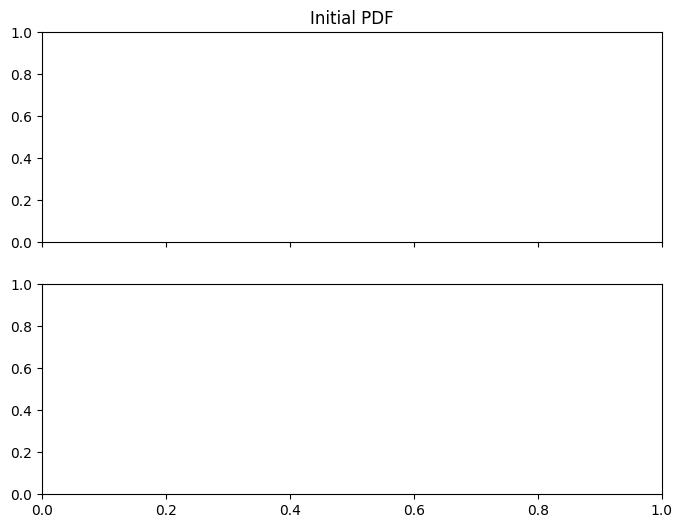

In [70]:
# We make use of the software package OTlib.py, which implements the approach of Sambridge et al. (2022).
# https://github.com/msambridge/waveform-ot/tree/main

# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.


# https://github.com/msambridge/waveform-ot/blob/main/Point_mass_demo_Fig_5.ipynb
# plot PDFs
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True,figsize=(8,6))
ax[0].set_title('Initial PDF')
ax[0].plot(fx,f,'go',lw=0.7)
for i in range(len(fx)):
    ax[0].plot([fx[i],fx[i]],[0.,f[i]],'k:',lw=0.7)
ax[1].plot(gx,g,'ro',lw=0.7)
for i in range(len(gx)):
    ax[1].plot([gx[i],gx[i]],[0.,g[i]],'k:',lw=0.7)
ax[1].set_title('Final PDF')
#plt.savefig('Figures/Initial_final_pointmasses.pdf')
plt.show()


print(w_1)
print(w_2)

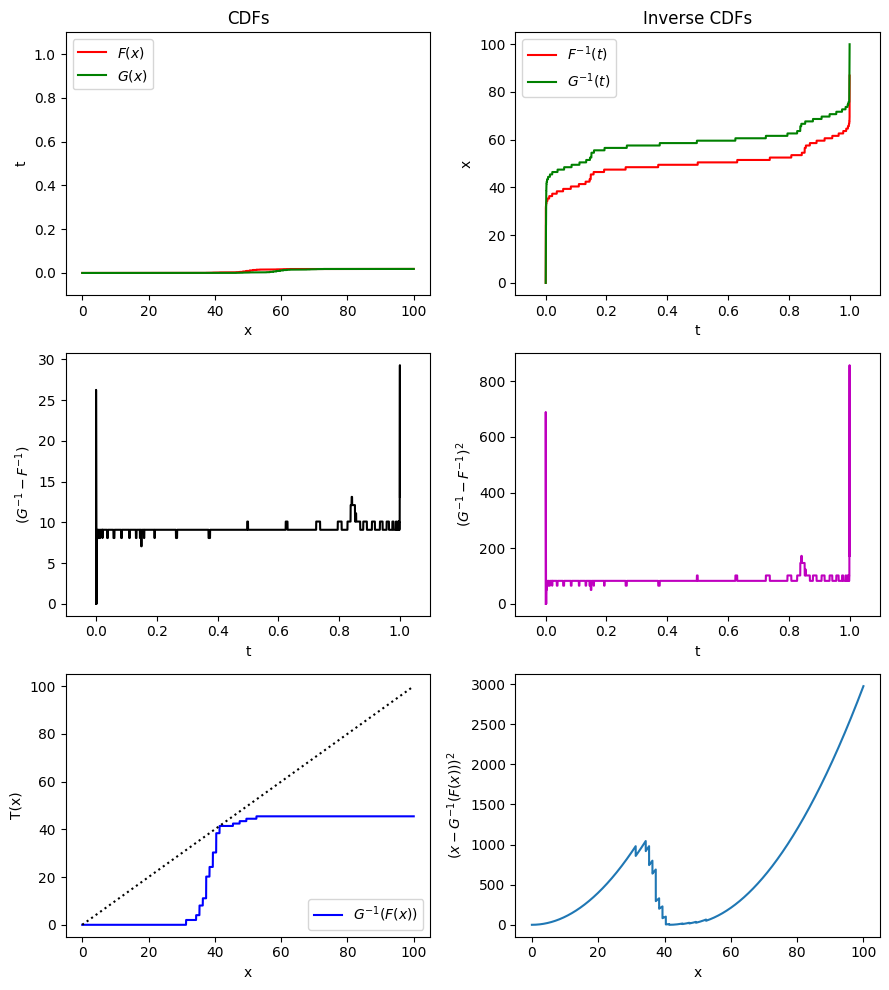

In [ ]:
# We make use of the software package OTlib.py, which implements the approach of Sambridge et al. (2022).
# https://github.com/msambridge/waveform-ot/tree/main

# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.


# https://github.com/msambridge/waveform-ot/blob/main/Point_mass_demo_Fig_5.ipynb
# Calculate a plot demonstrating Wasserstein calculation for point masses
if(True):
    nx=10000 # plot discretization 
    cf = source.cdf # Cumulative distribution of source point mass
    cg = target.cdf # Cumulative distribution of target point mass
    
    start = np.min((fx[0],gx[0]))+0.5*(np.max((fx[-1],gx[-1])-np.min((fx[0],gx[0]))))/nx 
    stop = np.max((fx[-1],gx[-1]))-0.5*(np.max((fx[-1],gx[-1])-np.min((fx[0],gx[0]))))/nx 
    x = np.linspace(start,stop,nx)   # x-axis evaluation points for plot
    t = np.linspace(0,1,nx)          # t-axis evaluation points for plot

    F = np.dot(f,np.transpose(list(map(lambda x: np.heaviside(x-fx,0.0), x)))) #cdf of f
    G = np.dot(g,np.transpose(list(map(lambda x: np.heaviside(x-gx,0.0), x)))) #cdf of g

    Fp = np.append(F,1.0) # tidy up upper end point for neatness of plot
    Gp = np.append(G,1.0) # tidy up upper end point for neatness of plot
    xp = np.append(x,np.max((fx[-1],gx[-1])))
    Fp = F
    Gp = G
    xp = x

    dfx = fx[1:]-fx[:-1] 
    IF = fx[0] + np.dot(dfx,np.transpose(list(map(lambda x: np.heaviside(x-cf[:-1],0.0), t))))
    dgx = gx[1:]-gx[:-1]
    IG = gx[0] + np.dot(dgx,np.transpose(list(map(lambda x: np.heaviside(x-cg[:-1],0.0), t))))
    iFGdiff = IF-IG # Difference in inverse Cummulative functions
    IGF = gx[0] + np.dot(dgx,np.transpose(list(map(lambda x: np.heaviside(x-cg[:-1],0.0), F))))
    xmIFGsq = np.multiply(x - IGF,x - IGF)

    OT.plotWasser(xp,Fp,Gp,t,IF,IG,x,IGF,xmIFGsq,iFGdiff)

In [ ]:
# We make use of the software package OTlib.py, which implements the approach of Sambridge et al. (2022).
# https://github.com/msambridge/waveform-ot/tree/main

# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.


# Display W1 and W2
print('W_1 = ',np.round(OT.wasser(source,target,distfunc='W1')[0],4))
print('W_2 = ',np.round(OT.wasser(source,target,distfunc='W2')[0],4))

W_1 =  9.2245
W_2 =  85.6534


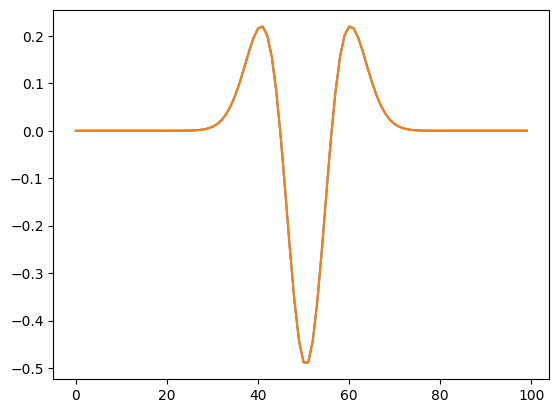

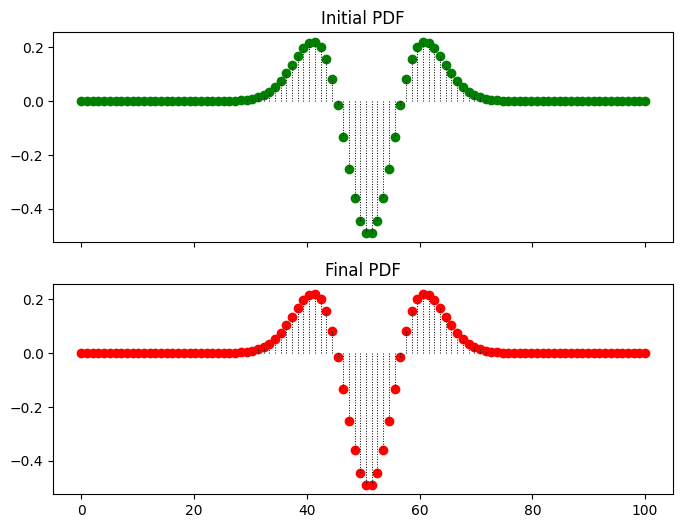

In [72]:
# We make use of the software package OTlib.py, which implements the approach of Sambridge et al. (2022).
# https://github.com/msambridge/waveform-ot/tree/main

# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.

from Imported_Libraries import OTlib as OT
from Imported_Libraries import ricker_util as ru 

# https://github.com/msambridge/waveform-ot/blob/main/Point_mass_demo_Fig_5.ipynb
# set up initial and final PDFs simple point masses
#fx = np.linspace(3, 14, 6)
fx = np.linspace(0, 100, 100)
#gx = np.linspace(7, 18, 6)
gx = np.linspace(0, 100, 100)
#f = np.array([0.2,0.01,0.18,0.21,0.2,0.2])   # initial distribution is two Gaussians
f = observed_data[:,1].flatten()
#g = np.array([0.18,0.07,0.2,0.05,0.27,0.23]) # final distribution is one Gaussian with same sum as f
g = realizations_seismic[1953][:,1].flatten()
plt.plot(f)
plt.plot(g)

# plot PDFs
fig, ax = plt.subplots(2, 1, sharex=True, sharey=True,figsize=(8,6))
ax[0].set_title('Initial PDF')
ax[0].plot(fx,f,'go',lw=0.7)
for i in range(len(fx)):
    ax[0].plot([fx[i],fx[i]],[0.,f[i]],'k:',lw=0.7)
ax[1].plot(gx,g,'ro',lw=0.7)
for i in range(len(gx)):
    ax[1].plot([gx[i],gx[i]],[0.,g[i]],'k:',lw=0.7)
ax[1].set_title('Final PDF')

#plt.savefig('Figures/Initial_final_pointmasses.pdf')
plt.show()

In [ ]:
# We make use of the software package OTlib.py, which implements the approach of Sambridge et al. (2022).
# https://github.com/msambridge/waveform-ot/tree/main

# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.


# https://github.com/msambridge/waveform-ot/blob/main/Ricker_Figs_1_7.ipynb

# choose grid to use
nugrid,ntgrid=40,512 # This is the discretization of the waveform window used to evaluated the density surface
lambdav = 0.03       # This is the distance scale factor used to calculate the density function (eqn. 17 of Sambridge et al. (2

trange = [0, nx]

grid = (trange[0], trange[1], -0.8, 1.2, nugrid,ntgrid) # specify grid for fingerprint
wfobs, wfobs_target = ru.BuildOTobjfromWaveform(fx,f,grid,lambdav=lambdav)

ru.fp.plot_LS(wfobs.dfield,wfobs,None,None,'Fingerprint of observed Double Ricker waveform','grey','grey',aspect=True) 

In [ ]:
# We make use of the software package OTlib.py, which implements the approach of Sambridge et al. (2022).
# https://github.com/msambridge/waveform-ot/tree/main

# Reference paper: Malcolm Sambridge, Andrew Jackson, y Andrew P Valentine,
# «Geophysical Inversion and Optimal Transport»,
# Geophysical Journal International 231, n.º 1 (21 de junio de 2022): 172-98,
# https://doi.org/10.1093/gji/ggac151.


# https://github.com/msambridge/waveform-ot/blob/main/Ricker_Figs_1_7.ipynb

wfs,wfsource = ru.BuildOTobjfromWaveform(gx,g,grid,lambdav=lambdav)

w1 = ru.CalcWasserWaveform(wfsource,wfobs_target,wfs,distfunc='W1')
w2 = ru.CalcWasserWaveform(wfsource,wfobs_target,wfs,distfunc='W2')
        
print(w1)
print(w2)

0.017967351309823083
0.0009442100367406843


#### Time-shifts Calculations

0.008


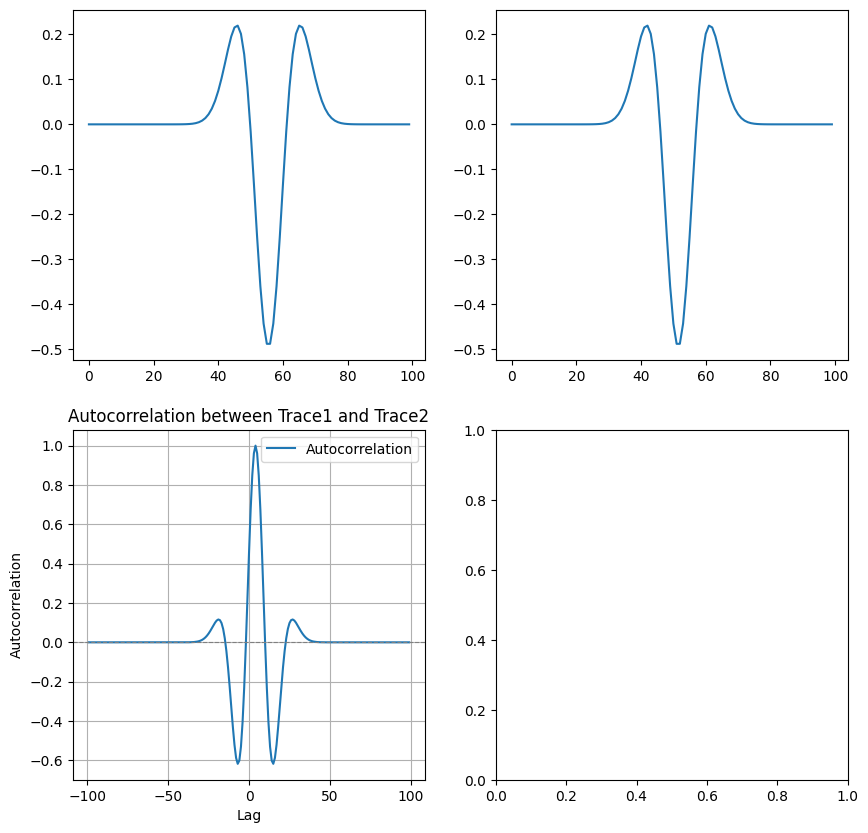

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create two 100x1 random traces
trace1 = initial_dn[:,50]  # First trace
trace2 = realizations_seismic[0][:,50]  # Second trace

# Step 2: Define a function to compute autocorrelation
def autocorrelation(x, y):
    """
    Compute the normalized autocorrelation of two signals x and y.
    """
    # Flatten the traces if they are 2D
    x = (x - np.mean(x))/np.std(x)
    y = (y - np.mean(y))/np.std(y)
    
    # Ensure both signals have the same length
    assert len(x) == len(y), "Traces must be of the same length."
    
    # Mean-centering the signals
    #x = x - np.mean(x)
    #y = y - np.mean(y)
    
    # Compute the cross-correlation using numpy.correlate
    correlation = np.correlate(x, y, mode='full')  # Full correlation
    normalization = np.sqrt(np.sum(x**2) * np.sum(y**2))  # Normalization factor
    autocorr = correlation / normalization  # Normalize the result
    
    # Return the central portion of the correlation (lags = -99 to +99)
    return autocorr

# Step 3: Compute the autocorrelation between trace1 and trace2

autocorr_result = autocorrelation(trace1, trace2)

lag = (np.argmax(autocorr_result) - 99) * dt0
print(lag)

# Step 4: Plot the autocorrelation
lags = np.arange(-99, 100)  # Lags corresponding to the autocorrelation result

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].plot(trace1)
axes[0, 1].plot(trace2)
axes[1, 0].plot(lags, autocorr_result, label='Autocorrelation')
axes[1, 0].axhline(0, color='gray', linestyle='--', linewidth=0.8)
axes[1, 0].set_title("Autocorrelation between Trace1 and Trace2")
axes[1, 0].set_xlabel("Lag")
axes[1, 0].set_ylabel("Autocorrelation")
axes[1, 0].legend()
axes[1, 0].grid()
plt.show()


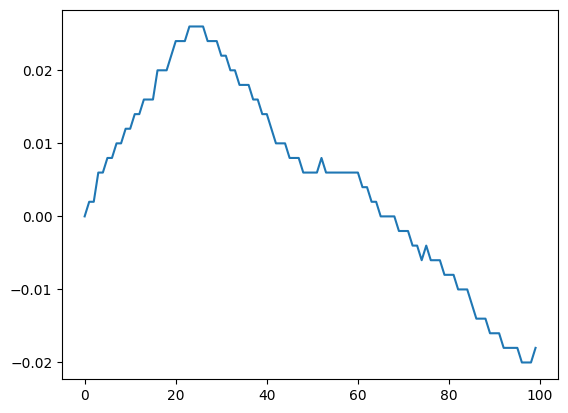

In [43]:
# Time-shifts for observed data vs on of the seismic realizations

lag = np.zeros((nx))
for i in range(nx):
    autocorr_result = autocorrelation(initial_dn[:,i], realizations_seismic[50][:,i])
    lag[i] = (np.argmax(autocorr_result) - 99) * dt0

plt.plot(lag)

In [294]:
# Time-shifts for observed data vs all seismic realizations

lag_per_point = np.zeros((len(realizations_seismic), nx))
lag_sum = np.zeros((len(realizations_seismic)))
lag_sum_squared = np.zeros((len(realizations_seismic)))
lag_sum_abs = np.zeros((len(realizations_seismic)))
lag_max = np.zeros((len(realizations_seismic)))
lag_mean = np.zeros((len(realizations_seismic)))
lag_std = np.zeros((len(realizations_seismic)))
errors_whole_section = np.zeros((len(realizations_seismic), nx*2-1))
lags_whole_section = np.zeros((len(realizations_seismic), nx*2-1))
min_error_index = np.zeros((len(realizations_seismic)))
min_error = np.zeros((len(realizations_seismic)))
errors_sum = np.zeros((len(realizations_seismic)))

for j in range(len(realizations_seismic)):   
    for i in range(nx):
        autocorr_result = autocorrelation(initial_dn[:,i], realizations_seismic[j][:,i])
        lag_per_point[j, i] = (np.argmax(autocorr_result) - 99) * 1 #dt0
    lag_sum[j] = np.sum(np.sum(lag_per_point[j, :]))
    lag_sum_squared[j] = np.sum(np.sum(lag_per_point[j, :]**2))
    lag_sum_abs[j] = np.sum(np.abs(lag_per_point[j, :]))
    lag_max[j] = np.min(np.abs(lag_per_point[j, :]))
    lag_mean[j] = np.mean(lag_per_point[j, :])
    lag_std[j] = np.std(lag_per_point[j, :])

    lags, errors = compute_error_vs_shift(initial_dn, realizations_seismic[j])
    lags_whole_section [j, :] = lags
    errors_whole_section[j, :] = errors
    errors_sum[j]=np.sum(errors_whole_section[j])
    
    min_error_index[j]= np.argmin(errors)
    min_error [j] = errors[np.argmin(errors)]


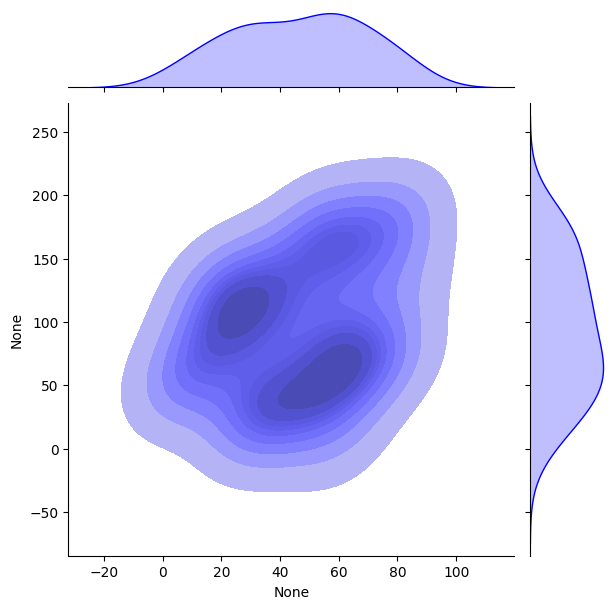

In [295]:
sns.jointplot(x=len_sc_list, y=variances, kind="kde", color="blue", fill=True)

#plt.xlabel("Length Parameter")
#plt.ylabel("Variance")
#plt.suptitle("Joint Distribution of Length Parameter and Variance", y=1)

plt.show()

4964778341.392932


C:\Users\cco\AppData\Local\Temp\ipykernel_21752\4100899817.py:5: RuntimeWarning: overflow encountered in exp
  lik = np.exp(-(similarity-min_similarity))


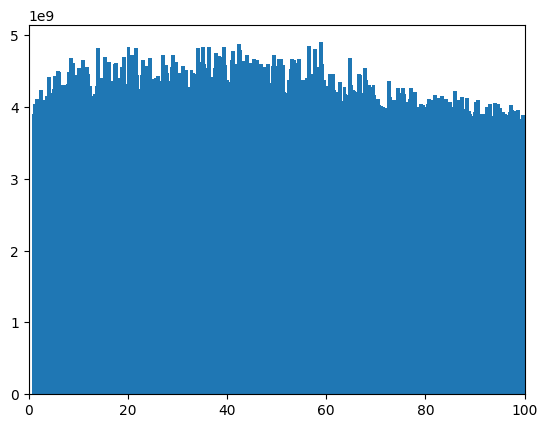

In [761]:
min_similarity = np.max(similarity)
epsilon = min_similarity * 1.0
print(epsilon)

lik = np.exp(-(similarity-min_similarity))

plt.bar(np.asarray(len_sc_list)[np.where(similarity<epsilon)], similarity[np.where(similarity<epsilon)])
plt.xlim(0, 100)
#plt.hist(lag_mean)
plt.show()

In [763]:
np.where(similarity<=epsilon)

(array([9081], dtype=int64),)

18.034552281452715
174.14778701154262


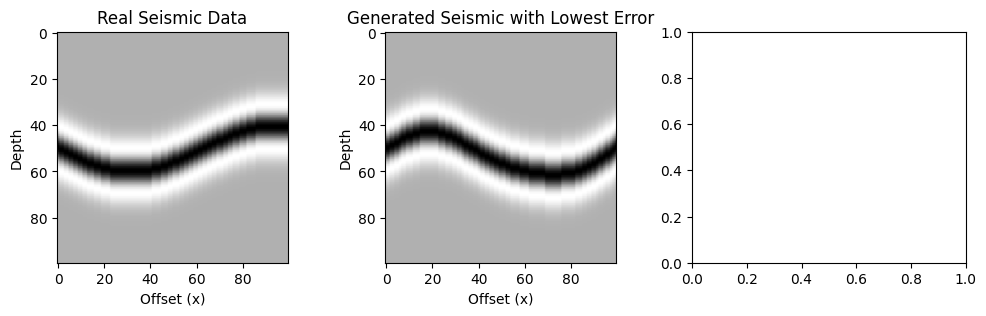

In [769]:
print(len_sc_list[6])
print(variances[6])

# Plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))



# Impedance
axes[0].imshow(initial_dn, cmap="gray")
axes[0].set_ylabel("Depth")
axes[0].set_xlabel("Offset (x)")
axes[0].set_title("Real Seismic Data")

# Seismic
import matplotlib as mpl
axes[1].imshow(realizations_seismic[9081], cmap="gray")
axes[1].set_ylabel("Depth")
axes[1].set_xlabel("Offset (x)")
axes[1].set_title("Generated Seismic with Lowest Error")

#plt.tight_layout()
plt.show()

In [445]:
np.where(abs(lag_sum)==np.min(abs(lag_sum)))

(array([ 464,  721, 1918], dtype=int64),)

In [465]:
len_sc_list[721]

46.48150214394804

In [61]:
#plt.scatter(np.asarray(len_sc_list)[np.where(similarity<=epsilon*2.0)], (lag_mean[np.where(similarity<=epsilon*2.0)]))
opt_sum_std_dists = (lag_sum**2 + lag_std**2)**(1/2)
np.where(opt_sum_std_dists<=np.min(opt_sum_std_dists)*1.5)
#plt.xlim(0, 100)

(array([3715, 6623], dtype=int64),)

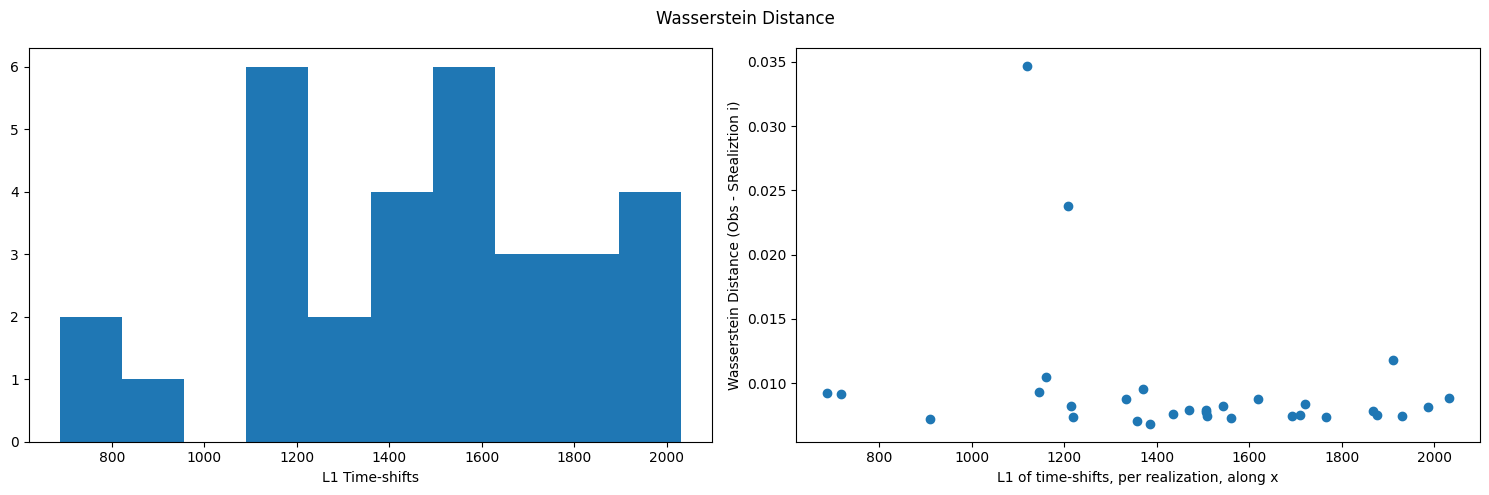

In [300]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#axes[0].scatter(len_sc_list, lag_sum)

fig.suptitle ("Wasserstein Distance")

axes[0].hist(lag_sum)
axes[0].set_xlabel("L1 Time-shifts")

axes[1].scatter(lag_sum, similarity)
#axes[1].set_title("Sum of absolute Lags vs similarity")
axes[1].set_xlabel("L1 of time-shifts, per realization, along x")
axes[1].set_ylabel("Wasserstein Distance (Obs - SRealiztion i)")

#axes[2].scatter(len_sc_list, lag_sum_abs)
#axes[2].set_title("Sum of Absolute Time-shifts")

plt.tight_layout()
plt.show()

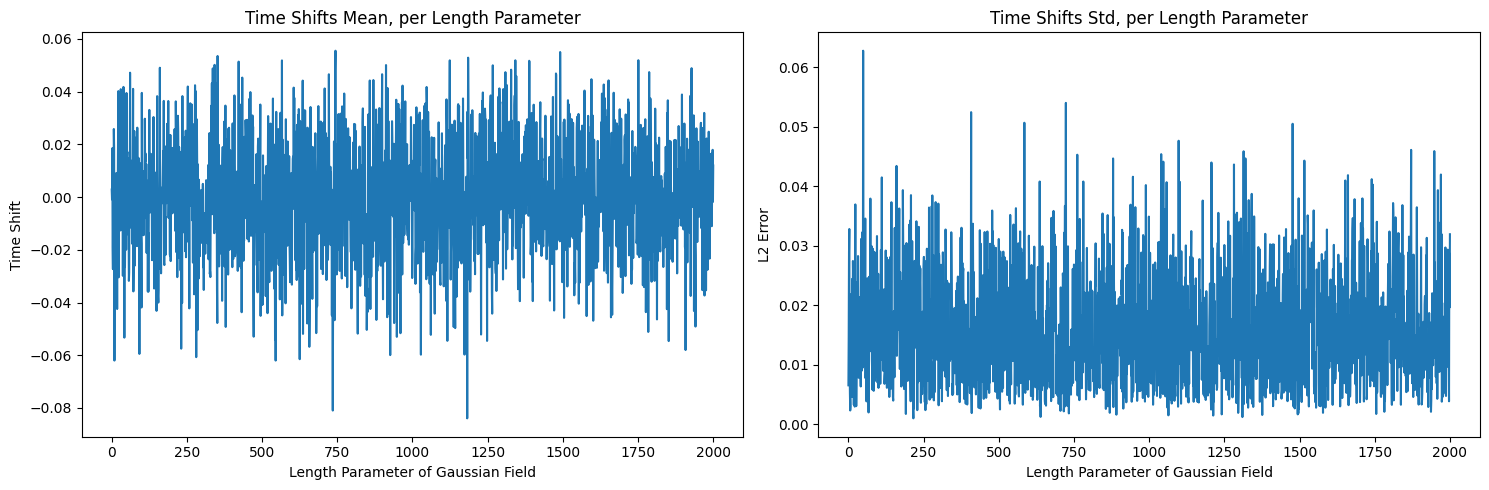

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))


#axes[0].plot(np.argwhere(abs(lag_sum)<5), abs(lag_sum[abs(lag_sum)<5]))
axes[0].plot(lag_mean)
axes[0].set_title("Time Shifts Mean, per Length Parameter")
axes[0].set_ylabel("Time Shift")
axes[0].set_xlabel("Length Parameter of Gaussian Field")

#axes[1].plot(np.argwhere(abs(similarity)<0.025), abs(similarity[abs(similarity)<0.025]))
axes[1].plot(np.abs(lag_std))
axes[1].set_title("Time Shifts Std, per Length Parameter")
axes[1].set_ylabel("L2 Error")
axes[1].set_xlabel("Length Parameter of Gaussian Field")

#axes[2].scatter(len_sc_list, lag_sum_abs)
#axes[2].set_title("Sum of Absolute Time-shifts")

plt.tight_layout()
plt.show()

In [852]:
temp = np.zeros((100))
wdi = np.zeros((200))
for i in range (-100, 100):
    if i < 0:
        temp[0:(101-abs(i))] = initial_dn[:,0].T.flatten()[(abs(i)-1):100]
    else:
        temp = np.zeros((100))
        temp[i:100] = initial_dn[:,0].T.flatten()[i:100]
    #wdi[i+100] = compute_wasserstein_distance(initial_dn[:,1].T.flatten()[0:100], temp)
    wdi[i+100] = compute_least_squares_misfit(initial_dn[:,0].T.flatten()[0:100], temp)

Text(0.5, 0, 'Time')

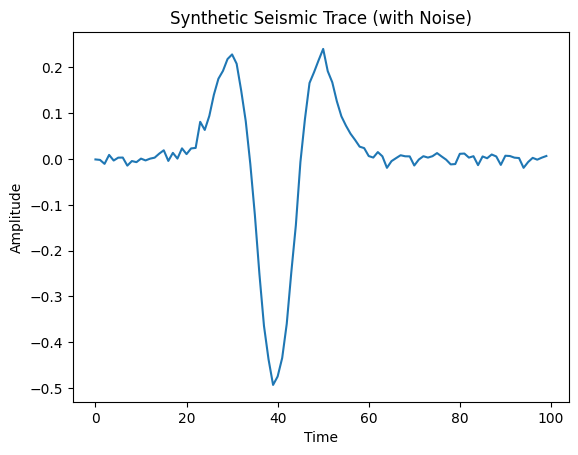

In [853]:
#plt.plot(realizations_seismic[0].T.flatten()[0:100])
plt.plot(initial_dn[:,0].T.flatten()[0:100])
plt.title("Synthetic Seismic Trace (with Noise)")
plt.ylabel("Amplitude")
plt.xlabel("Time")

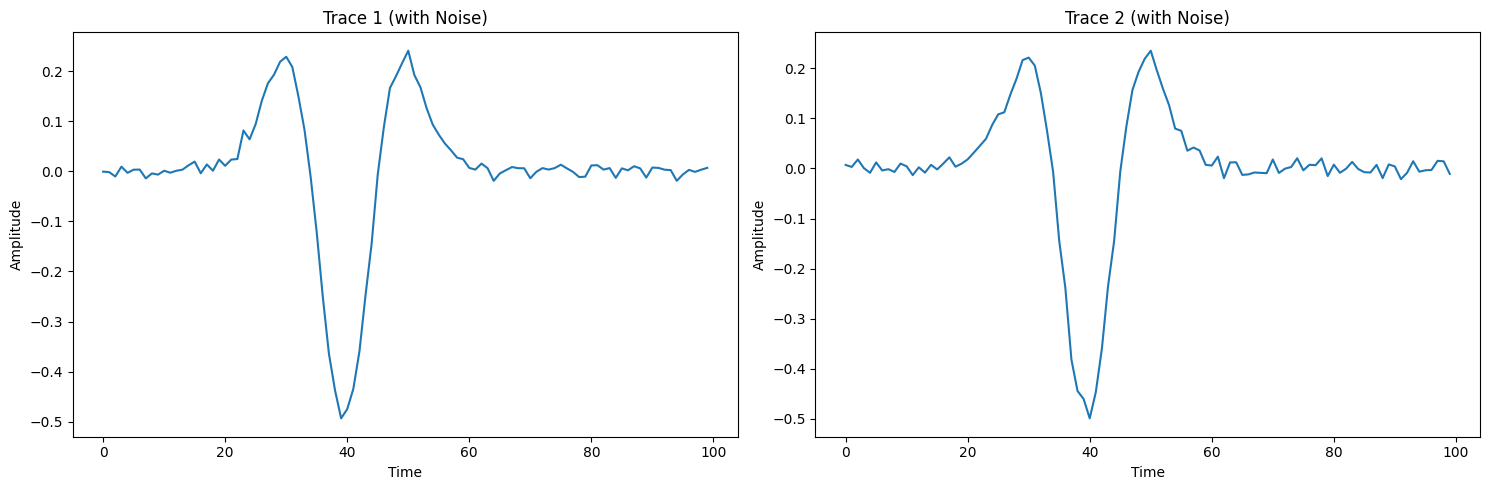

In [854]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#axes[0].scatter(len_sc_list, lag_sum)
axes[0].plot(initial_dn[:,0].T.flatten()[0:100])
axes[0].set_title("Trace 1 (with Noise)")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("Time")


#axes[1].set_title("Sum of absolute Lags vs similarity")
axes[1].plot(initial_dn[:,1].T.flatten()[0:100])
axes[1].set_title("Trace 2 (with Noise)")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlabel("Time")



plt.tight_layout()
plt.show()

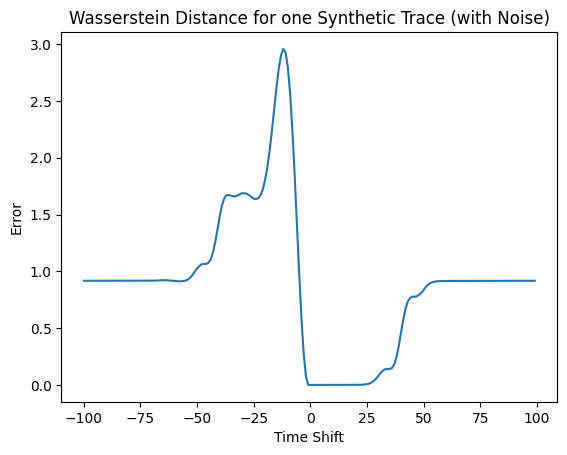

In [855]:
plt.plot(np.linspace(-100, 99, 200), wdi)
#plt.title("Least-squares Error for one Synthetic Trace (with Noise)")
plt.title("Wasserstein Distance for one Synthetic Trace (with Noise)")
plt.ylabel("Error")
plt.xlabel("Time Shift")
plt.show()

In [758]:
initial_dn.shape

(100, 100)

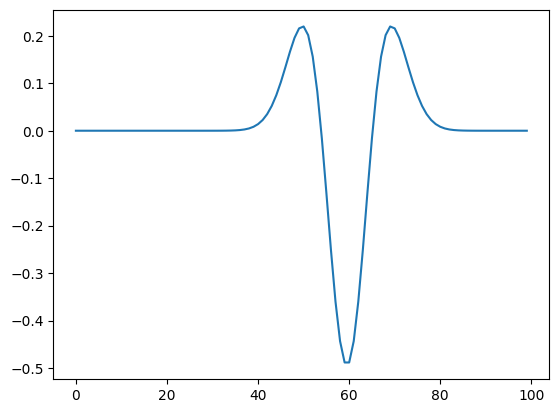

In [773]:
plt.plot(np.roll(initial_di[:,10],20))

In [863]:
np.shape(realizations_seismic[1])

(100, 100)

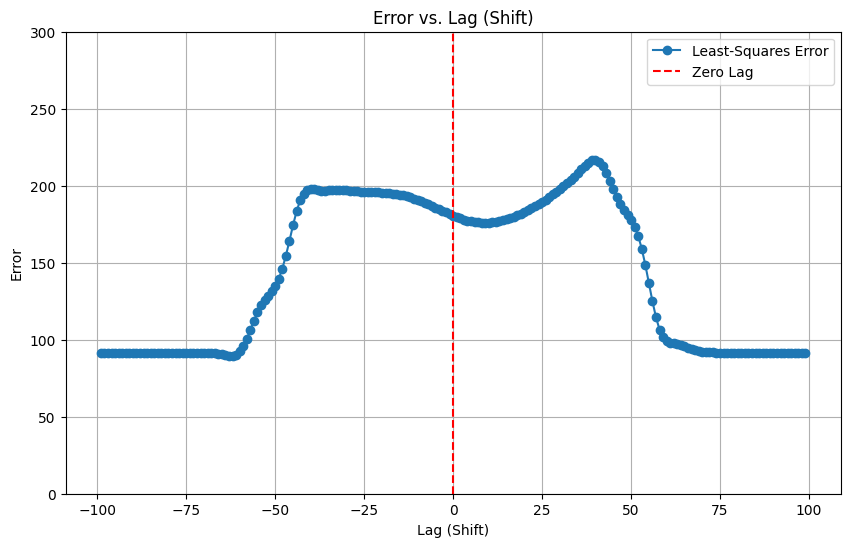

Minimum error: 89.59556701701139, at lag: -62


In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample signal (same signal for both comparisons)
n_samples = 100
#signal1 = np.sin(np.linspace(0, 2 * np.pi, n_samples))  # Example signal
#signal2 = signal1.copy()  # Same signal, no noise or transformation
signal1 = np.asarray(realizations_seismic[1])
signal2 = np.roll(np.asarray(realizations_seismic[5]), 0, axis=0)

# Function to compute error vs shift (least-squares)
def compute_error_vs_shift(signal1, signal2, method="least_squares"):
    n = len(signal1)
    lags = np.arange(-n + 1, n)  # Full range of lags
    errors = []

    for lag in lags:
        if lag < 0:
            # Shift signal2 to the left
            shifted_signal2 = np.roll(signal2, lag)
            shifted_signal2[lag:] = 0  # Zero padding on the right
        elif lag > 0:
            # Shift signal2 to the right
            shifted_signal2 = np.roll(signal2, lag)
            shifted_signal2[:lag] = 0  # Zero padding on the left
        else:
            # No shift
            shifted_signal2 = signal2

        # Compute error based on the selected method
        if method == "least_squares":
            error = compute_least_squares_misfit(signal1, shifted_signal2)
        elif method == "wasserstein":
            error = compute_OT_2(signal1, shifted_signal2)
        else:
            raise ValueError("Unknown method. Use 'least_squares' or 'wasserstein'.")

        errors.append(error)

    return lags, np.array(errors)

# Compute errors for the same signal
lags, errors = compute_error_vs_shift(signal1, signal2, method="least_squares")

# Plot error vs lag
plt.figure(figsize=(10, 6))
plt.plot(lags, errors, label="Least-Squares Error", marker='o')
plt.axvline(0, color='red', linestyle='--', label="Zero Lag")
plt.title("Error vs. Lag (Shift)")
plt.xlabel("Lag (Shift)")
plt.ylabel("Error")
plt.ylim(0, 300)
plt.legend()
plt.grid()
plt.show()

# Print minimum error and corresponding lag
min_error_index = np.argmin(errors)
print(f"Minimum error: {errors[min_error_index]}, at lag: {lags[min_error_index]}")


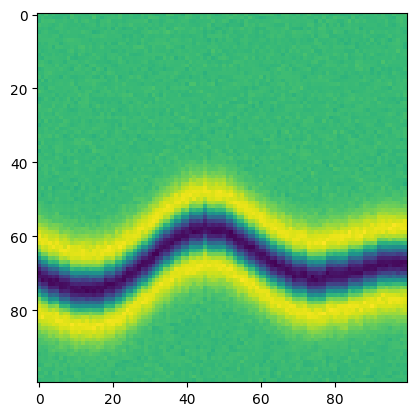

In [886]:
plt.imshow(np.roll(np.asarray(realizations_seismic[1]), 30, axis=0))

In [224]:
grid_line.reshape((10,1)).shape

(10, 1)

In [ ]:
# 1D SEQUENTIAL GAUSSIAN SIMULATION WITH COVARIANCE MATRIX CALCULATION


# RBF kernel function
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = np.sum((x1 - x2)**2)
    #dists = cdist(x1, x2, 'euclidean')**2

    #return variance * np.exp(-0.5 * sqdist / length_scale**2)

    #return variance * np.exp(-0.5 * dists / length_scale**2)
    return variance**2 * (1 - np.exp(- ((np.pi/2) * sqdist / length_scale)**2))

# Matern kernel function
def matern_kernel(x1, x2, length_scale, nu, variance):
    
    # Calculate the Euclidean distance between points
    #d = np.sqrt(np.sum((x1 - x2)**2, axis=-1))
    d = np.linalg.norm(np.array(x1) - np.array(x2))
    #d = cdist(x1, x2, 'euclidean')
    
    # Special case where nu is large (approximates RBF kernel)
    if nu == np.inf:
        return variance * np.exp(-0.5 * (d / length_scale)**2)
    
    # Compute the Matern kernel
    scaling_factor = 2**(1.0 - nu) / gamma(nu)
    distance_term = np.sqrt(2 * nu) * d / length_scale
    matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
        
    # Handle the case when distance is zero to avoid NaNs
    matern_value = np.where(d == 0.0, 1, matern_value)
    #matern_value = np.nan_to_num(matern_value, variance)
    
    return variance * matern_value

# Variogram model (spherical)
def variogram(h, range_a, sill, nugget):
    """ Spherical variogram model """
    h = np.abs(h)
    return np.where(h < range_a,
                    nugget + sill * (1.5 * (h / range_a) - 0.5 * (h / range_a)**3),
                    nugget + sill)




obs_coords_2D = np.array([[0], [99]])  # 3 known points with x and z coordinates
obs_values_2D = np.array([50, 50])  # Observed values (1D scalars)
grid_line = np.asarray(np.linspace(0, 99, 100)).reshape((100,1))

# Function to perform SGS
def sequential_gaussian_simulation(X_train, y_train, X, kernel, length_scale, variance, num_simulations):
    simulations_mean = np.zeros((num_simulations, len(X)))
    simulations_sigma = np.zeros((num_simulations, len(X)))
    for s in range(num_simulations):
        y_sim = np.zeros(len(X))
        y_sigma = np.zeros(len(X))
        for i, xi in enumerate(X):
            X_all = np.vstack([X_train, X[:i+1]])
            K = np.zeros((len(X_all), len(X_all)))
            for m in range(len(X_all)):
                for n in range(len(X_all)):
                    K[m, n] = kernel(X_all[m], X_all[n], length_scale, variance)
            
            K_train = K[:len(X_train) + i, :len(X_train) + i]
            K_train_inv = np.linalg.inv(K_train + 1e-8 * np.eye(len(K_train)))
            
            K_s = K[:len(X_train) + i, len(X_train) + i:len(X_train) + i + 1]
            K_s = np.round_(K_s, 8)
            K_ss = K[len(X_train) + i:len(X_train) + i + 1, len(X_train) + i:len(X_train) + i + 1]
            
            mu = K_s.T.dot(K_train_inv).dot(np.append(y_train, y_sim[:i]))
            #sigma = np.max((K_ss - K_s.T.dot(K_train_inv).dot(K_s), 0))
            sigma = np.abs(K_ss - K_s.T.dot(K_train_inv).dot(K_s))
            y_sim[i] = np.random.normal(mu, np.sqrt(sigma))
            y_sigma[i] = sigma
            
        simulations_mean[s, :] = y_sim
        simulations_sigma[s, :] = y_sigma

        #print(simulations_mean[s, :])
        #print(simulations_sigma[s, :])

    return simulations_mean, simulations_sigma

# Perform SGS
length_scale = 30
variance = 50
num_simulations = 5
simulations_mean, simulations_sigma = sequential_gaussian_simulation(obs_coords_2D,
                                             obs_values_2D,
                                             grid_line,
                                             rbf_kernel, length_scale,
                                             variance,
                                             num_simulations)

#print(f"Out function: {simulations_mean}")
#print(f"Out function: {simulations_sigma}")

#plt.plot(obs_coords_2D, obs_values_2D, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(grid_line, simulations_mean[i], label=f'Simulation {i+1}', lw=2)
    plt.fill_between(
        simulations_mean[i],
        simulations_mean[i] - 1.96 * simulations_sigma[i],
        simulations_mean[i] + 1.96 * simulations_sigma[i],
        alpha=0.4,
        label=r"95% confidence interval",
        color='green',
    )


plt.title('Sequential Gaussian simulation')
plt.xlabel('Offset (m)')
plt.ylabel('Depth (m)')

plt.ylim((0, 100))
plt.gca().invert_yaxis()
plt.xlim((0, 100))

#plt.legend()

plt.show()

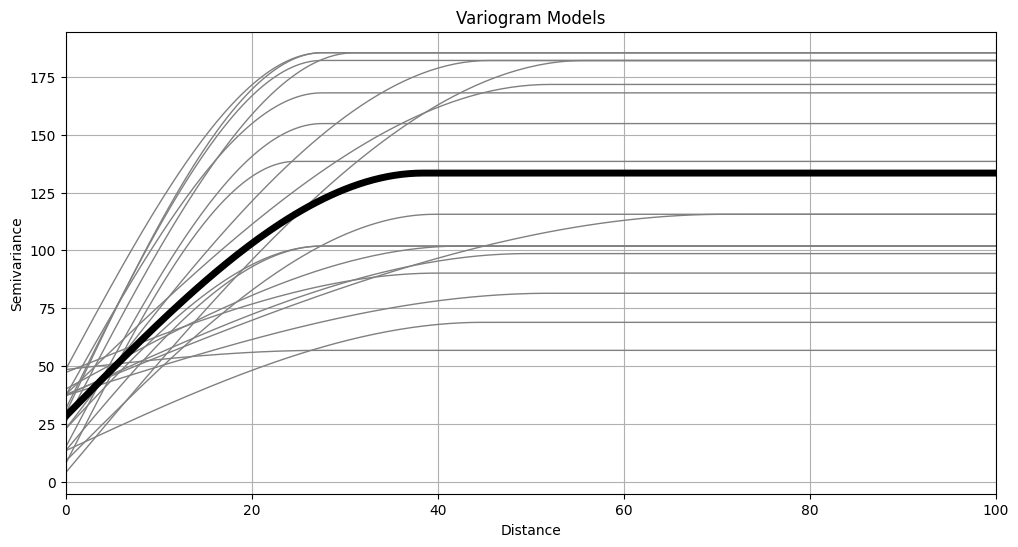

In [794]:
def plot_variogram(range_, sill, nugget, color, linewidth):
    """
    Plot a variogram using the spherical model.
    
    Parameters:
    range_ (float): The range of the variogram (distance at which the variogram reaches the sill).
    sill (float): The sill of the variogram (the maximum value).
    nugget (float): The nugget of the variogram (value at zero distance).
    """
    # Generate distances between 0 and the range
    distances = np.linspace(0, range_*10, 1000)
    
    # Calculate the spherical variogram model
    gamma = nugget + (sill - nugget) * (1.5 * (distances / range_) - 0.5 * (distances / range_)**3)
    gamma[distances > range_] = sill  # Cap the variogram at the sill beyond the range
    
    # Plot the variogram
    #plt.figure(figsize=(12, 3))
    plt.plot(distances, gamma, label="Spherical Variogram", color=color, linewidth=linewidth)
    plt.title("Variogram Models")
    plt.xlim(0 ,100)
    plt.xlabel("Distance")
    plt.ylabel("Semivariance")
    plt.grid(True)
    #plt.legend()
    #plt.show()

# Example usage
n_variog = 20
range_most_prob = np.random.choice(len_sc_list, size=n_variog, p=l_)
variances_most_prob = np.random.choice(variances, size=n_variog, p=l_)
nuggets_most_prob = np.random.choice(nuggets, size=n_variog, p=l_)
plt.figure(figsize=(12, 6))
for i in range (n_variog):
    plot_variogram(range_=range_most_prob[i],
                   sill=variances_most_prob[i],
                   nugget=nuggets_most_prob[i], color='gray', linewidth=1.0)
plot_variogram(range_=np.mean(range_most_prob),
                   sill=np.mean(variances_most_prob),
                   nugget=np.mean(nuggets_most_prob), color='black', linewidth=5.0)


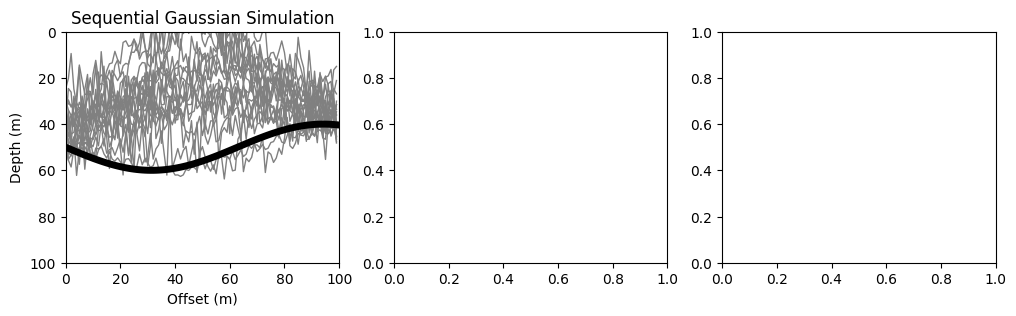

In [929]:
# Conditioned SRF

#structure_type = 'sin'
#structure_depth = 50
#structure_radius = 20
#struct_dip=0.3
#structure_freq = 0.05
#structure_amplitude = 10
bd = create_structure_boundary(structure_type, structure_depth, structure_radius, struct_dip, structure_amplitude, structure_freq)

bh_locations = [0, 99] # Assume left side is know point
bh_values = [bd[0], bd[-1]] # Assume right side is know point
# Conditioning of the SRF to the specified points
#model = gs.Gaussian(dim=1, var=100, len_scale=40)
#krige = gs.krige.Simple(model, bh_locations, bh_values)
#cond_srf = gs.CondSRF(krige)


n_iter = n_variog
realizations_SGS = np.zeros((n_iter, nx))
for i in range(n_variog):
    model = gs.Gaussian(dim=1, len_scale=range_most_prob[i], var=variances_most_prob[i], nugget=nuggets_most_prob[i])
    krige = gs.krige.Simple(model, bh_locations, bh_values)
    cond_srf = gs.CondSRF(krige)
    realizations_SGS[i] = cond_srf(x_offset)


fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for j in range(n_iter):
    axes[0].plot(x_offset, realizations_SGS[j, :], lw=1, color='grey')

axes[0].plot(x_offset, bd, lw=5, color='black')

axes[0].set_title('Sequential Gaussian Simulation')
axes[0].set_xlabel('Offset (m)')
axes[0].set_ylabel('Depth (m)')
axes[0].set_ylim((0, 100))
#plt.gca().invert_yaxis()
axes[0].set_xlim((0, 100))
axes[0].yaxis.set_inverted(True)
#axes[0].legend()
plt.show()